In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report as report
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import confusion_matrix as cm
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from scipy import stats
from catboost import CatBoostClassifier, Pool
import tqdm
import shap
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as pipeline
from sklearn.ensemble import VotingClassifier
from math import ceil

In [2]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

## Exploratory Data Analysis
---

In [11]:
cl_blue = '#82D1F1'
cl_red = '#FF6961'

### Distribusi Data Numerik

In [3]:
def coolhist(column, color, name, ax, nbins):
    if nbins == 0:
        q1 = column.quantile(q=0.25)
        q3 = column.quantile(q=0.75)
        IQR = q3 - q1
        h = 2*IQR*int(len(column.index))**(-1/3)
        nbins = int((column.max() - column.min())/h)
        print(nbins)
    else:
        nbins = nbins
    column.plot.hist(ax=ax, color=color, bins=nbins, edgecolor='black', title=name)

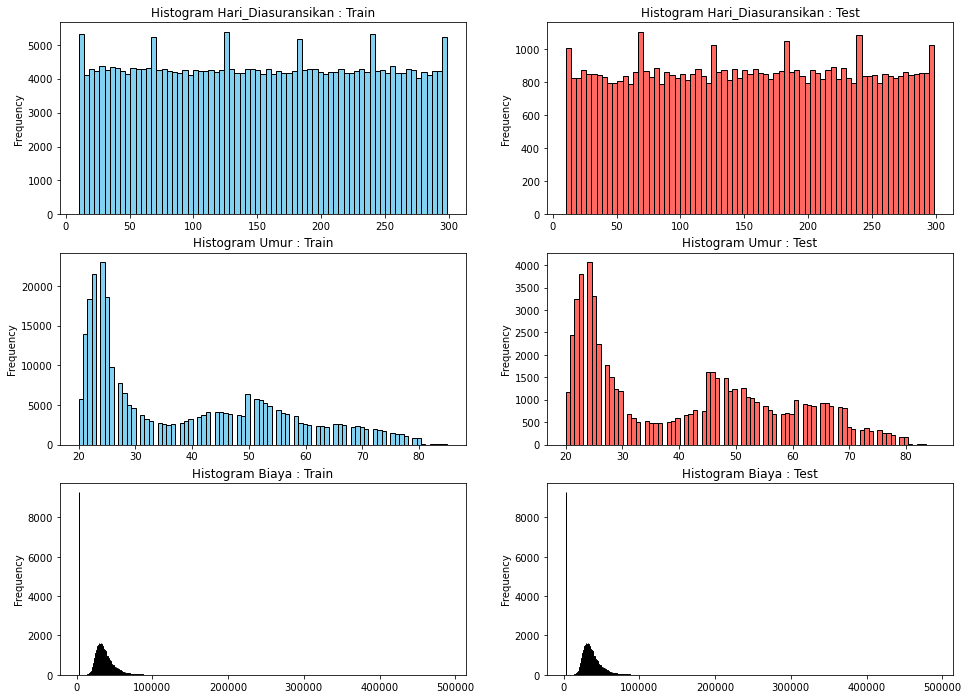

In [4]:
fig, ([ax1, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(3, 2, figsize=(16,12))

coolhist(train['Hari_Diasuransikan'], '#82D1F1', 'Histogram Hari_Diasuransikan : Train', ax1, 71)
coolhist(test['Hari_Diasuransikan'], '#FF6961', 'Histogram Hari_Diasuransikan : Test', ax2, 71)
coolhist(train['Umur'], '#82D1F1', 'Histogram Umur : Train', ax3, 84)
coolhist(test['Umur'], '#FF6961', 'Histogram Umur : Test', ax4, 84)
coolhist(test['Biaya'], '#82D1F1', 'Histogram Biaya : Train', ax5, 652)
coolhist(test['Biaya'], '#FF6961', 'Histogram Biaya : Test', ax6, 652)

In [5]:
train.groupby('Umur')['Umur'].value_counts().sort_values(ascending=False).head(10)

Umur  Umur
24.0  24.0    23033
23.0  23.0    21560
25.0  25.0    18636
22.0  22.0    18367
21.0  21.0    13996
26.0  26.0     9776
27.0  27.0     7748
28.0  28.0     6449
50.0  50.0     6316
51.0  51.0     5789
Name: Umur, dtype: int64

In [6]:
test.groupby('Umur')['Umur'].value_counts().sort_values(ascending=False).head(10)

Umur  Umur
24.0  24.0    4072
23.0  23.0    3800
25.0  25.0    3303
22.0  22.0    3236
21.0  21.0    2449
26.0  26.0    2242
27.0  27.0    1779
45.0  45.0    1628
46.0  46.0    1617
28.0  28.0    1496
Name: Umur, dtype: int64

In [7]:
# Dists Missing
print('Kolmogorov-Smirnov Tests:')
print('-Hari_Diasuransikan:')
print(stats.ks_2samp(train['Hari_Diasuransikan'], test['Hari_Diasuransikan']))
print('-Umur:')
print(stats.ks_2samp(train['Umur'], test['Umur']))
print('-Biaya:')
print(stats.ks_2samp(train['Biaya'], test['Biaya']))

Kolmogorov-Smirnov Tests:
-Hari_Diasuransikan:
KstestResult(statistic=0.02211854676267455, pvalue=4.837805991158851e-28)
-Umur:
KstestResult(statistic=0.05621752740303387, pvalue=6.593721204575883e-179)
-Biaya:
KstestResult(statistic=0.06492331339752155, pvalue=1.6099716101311423e-238)


In [8]:
# Dists No Missing
roldf = train.dropna().copy()
doldf = test.dropna().copy()
print('Kolmogorov-Smirnov Tests [NO MISSING VALUES]:')
print('-Hari_Diasuransikan:')
print(stats.ks_2samp(roldf['Hari_Diasuransikan'], doldf['Hari_Diasuransikan']))
print('-Umur:')
print(stats.ks_2samp(roldf['Umur'], doldf['Umur']))
print('-Biaya:')
print(stats.ks_2samp(roldf['Biaya'], doldf['Biaya']))

Kolmogorov-Smirnov Tests [NO MISSING VALUES]:
-Hari_Diasuransikan:
KstestResult(statistic=0.009365446174616765, pvalue=0.24096749566291065)
-Umur:
KstestResult(statistic=0.12019394125314753, pvalue=9.492902575944933e-152)
-Biaya:
KstestResult(statistic=0.03314823405569223, pvalue=6.587742107379246e-12)


### Proporsi Target

In [9]:
def targetbar(name, column, ax):
    train.groupby(column)['Target'].value_counts().plot.bar(ax=ax, edgecolor='black', color=[cl_red, cl_blue], rot=15, title=name)

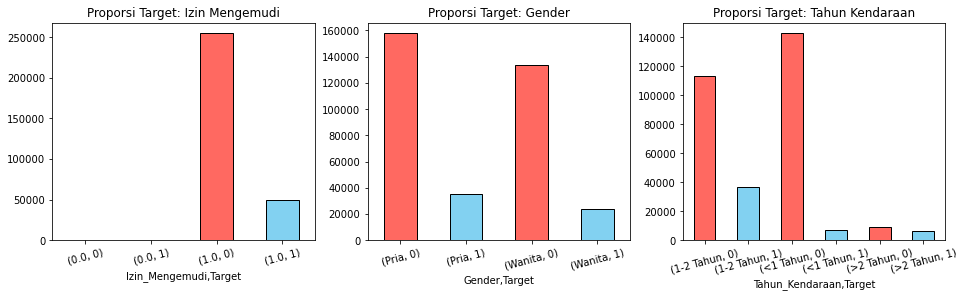

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
targetbar('Proporsi Target: Izin Mengemudi', 'Izin_Mengemudi', ax1)
targetbar('Proporsi Target: Gender', 'Gender', ax2)
targetbar('Proporsi Target: Tahun Kendaraan', 'Tahun_Kendaraan', ax3)

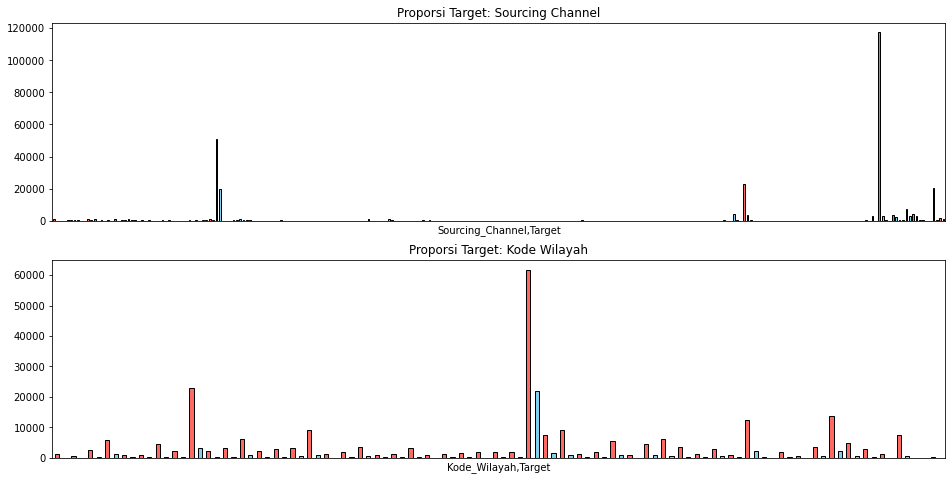

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,8))
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
targetbar('Proporsi Target: Sourcing Channel', 'Sourcing_Channel', ax1)

targetbar('Proporsi Target: Kode Wilayah', 'Kode_Wilayah', ax2)
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

### Proporsi kategori tiap kolom

<AxesSubplot:title={'center':'Proporsi Kategori: Tahun_Kendaraan'}>

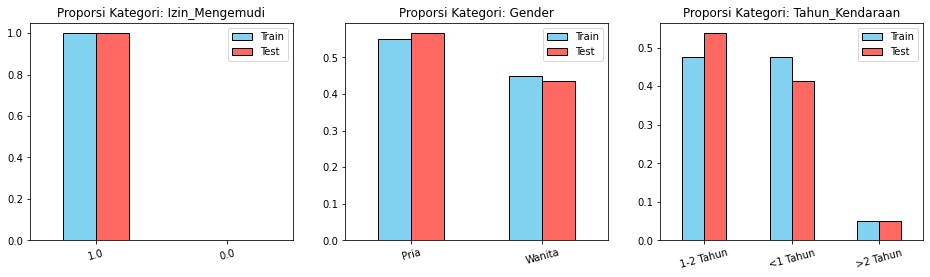

In [14]:
# Proportion
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
(train['Izin_Mengemudi'].value_counts()/train['Izin_Mengemudi'].value_counts().sum()).rename('Train').to_frame().join((test['Izin_Mengemudi'].value_counts()/test['Izin_Mengemudi'].value_counts().sum()).rename('Test').to_frame()).plot.bar(ax=ax1, color=['#82D1F1','#FF6961'], edgecolor='black', rot=15, title='Proporsi Kategori: Izin_Mengemudi')
(train['Gender'].value_counts()/train['Gender'].value_counts().sum()).rename('Train').to_frame().join((test['Gender'].value_counts()/test['Gender'].value_counts().sum()).rename('Test').to_frame()).plot.bar(ax=ax2, color=['#82D1F1','#FF6961'], edgecolor='black', rot=15, title='Proporsi Kategori: Gender')
(train['Tahun_Kendaraan'].value_counts()/train['Tahun_Kendaraan'].value_counts().sum()).rename('Train').to_frame().join((test['Tahun_Kendaraan'].value_counts()/test['Tahun_Kendaraan'].value_counts().sum()).rename('Test').to_frame()).plot.bar(ax=ax3, color=['#82D1F1','#FF6961'], edgecolor='black', rot=15, title='Proporsi Kategori: Tahun_Kendaraan')

<AxesSubplot:title={'center':'Proporsi Kategori: Sourcing Channel'}>

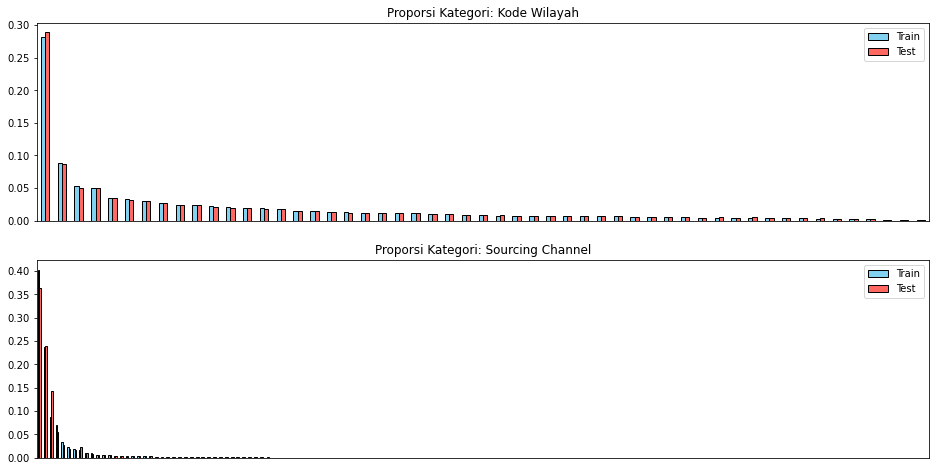

In [15]:
# Proportion
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,8))
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
(train['Kode_Wilayah'].value_counts()/train['Kode_Wilayah'].value_counts().sum()).rename('Train').to_frame().join((test['Kode_Wilayah'].value_counts()/test['Kode_Wilayah'].value_counts().sum()).rename('Test').to_frame()).plot.bar(ax=ax1, color=['#82D1F1','#FF6961'], edgecolor='black', rot=15, title='Proporsi Kategori: Kode Wilayah')
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
(train['Sourcing_Channel'].value_counts()/train['Sourcing_Channel'].value_counts().sum()).rename('Train').to_frame().join((test['Sourcing_Channel'].value_counts()/test['Sourcing_Channel'].value_counts().sum()).rename('Test').to_frame()).plot.bar(ax=ax2, color=['#82D1F1','#FF6961'], edgecolor='black', rot=15, title='Proporsi Kategori: Sourcing Channel')

### Outlier Detection

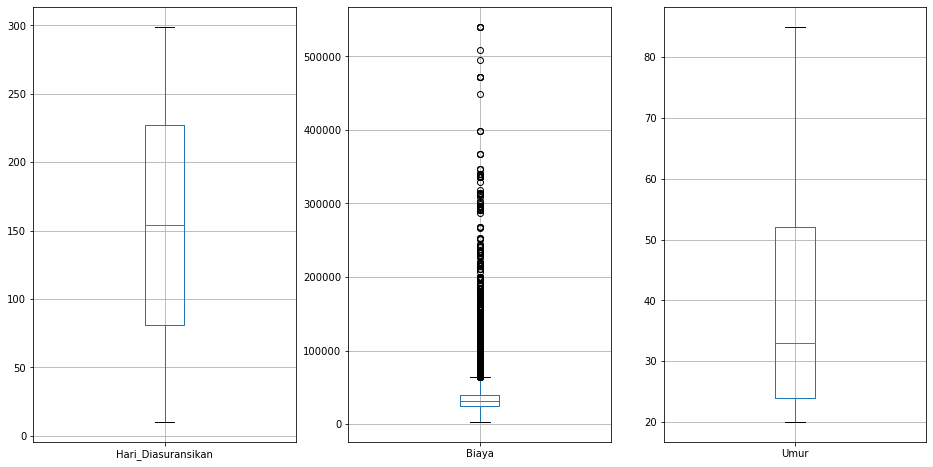

In [16]:
# Outliers
fig1, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,8))
train.boxplot('Hari_Diasuransikan', ax=ax1)
train.boxplot('Biaya', ax=ax2)
train.boxplot('Umur', ax=ax3)
plt.show()

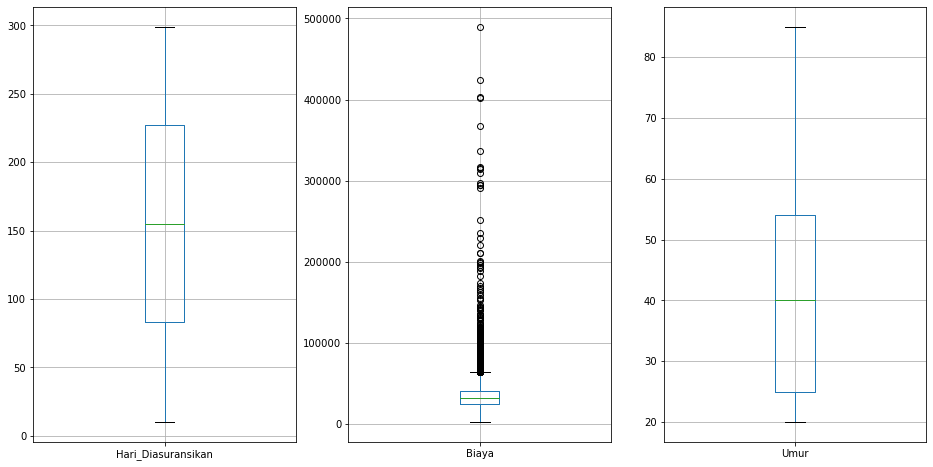

In [17]:
# Outliers
fig1, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,8))
test.boxplot('Hari_Diasuransikan', ax=ax1)
test.boxplot('Biaya', ax=ax2)
test.boxplot('Umur', ax=ax3)
plt.show()

### Visualisasi Korelasi

<AxesSubplot:>

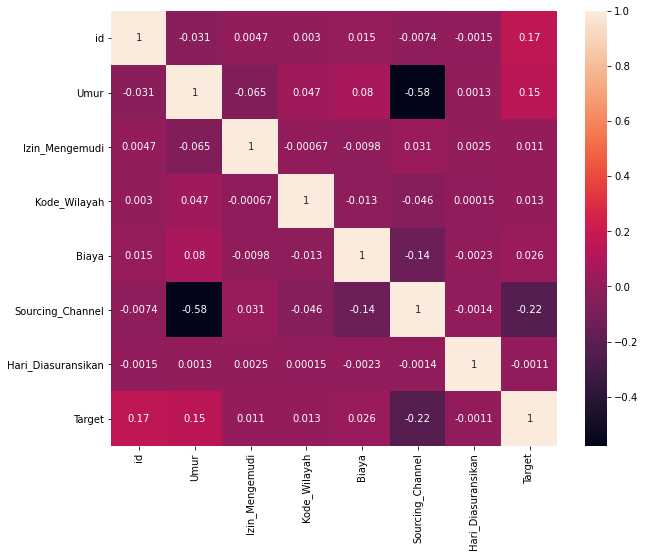

In [18]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(train.corr(), annot=True, ax=ax)

### Pemeriksaan missing values

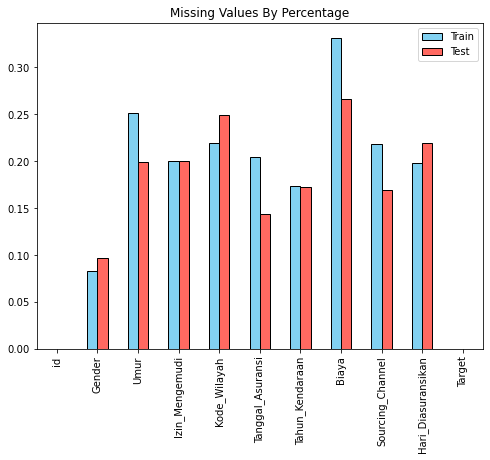

In [22]:
# Observe Missing Values
dfnulltable = pd.concat([train.isnull().sum()/len(train.index),test.isnull().sum()/len(test.index)],axis=1)
dfnulltable.columns =['Train','Test']
fig, (ax1) = plt.subplots(figsize=(8,6))
dfnulltable.plot.bar(ax=ax1, color=['#82D1F1','#FF6961'], title='Missing Values By Percentage', edgecolor='black')
plt.show()

### Pemeriksaan proporsi target

<AxesSubplot:title={'center':'Proporsi Target Dataset Train'}, ylabel='Target'>

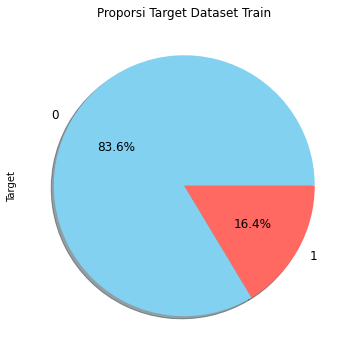

In [23]:
fig, (ax1) = plt.subplots(figsize=(8,6))
train['Target'].value_counts().plot.pie(ax=ax1, colors=[cl_blue, cl_red], title='Proporsi Target Dataset Train', fontsize=12, autopct='%1.1f%%', shadow=True)

### Memeriksa ID duplikat pada train dan test

In [24]:
# Duplicate Ids
test[test['id'].isin(train['id'])]

,id,Gender,Umur,Izin_Mengemudi,Kode_Wilayah,Tanggal_Asuransi,Tahun_Kendaraan,Biaya,Sourcing_Channel,Hari_Diasuransikan
9,306525,Pria,62.0,NaN,5.0,12/19/2019,1-2 Tahun,NaN,NaN,NaN
18,448635,Pria,NaN,NaN,23.0,7/8/2018,1-2 Tahun,NaN,NaN,256.0
38,12028,Pria,64.0,1.0,13.0,10/1/2019,1-2 Tahun,53081.0,124.0,135.0
76,372649,Pria,NaN,1.0,28.0,NaN,>2 Tahun,2630.0,55.0,218.0
86,179464,Wanita,64.0,1.0,NaN,1/17/2019,1-2 Tahun,NaN,26.0,40.0
...,...,...,...,...,...,...,...,...,...,...
78214,20462,Pria,61.0,1.0,8.0,NaN,1-2 Tahun,2630.0,156.0,49.0
78216,209366,Wanita,NaN,1.0,9.0,10/4/2019,1-2 Tahun,23239.0,13.0,123.0
78221,68091,Wanita,68.0,1.0,28.0,NaN,1-2 Tahun,41176.0,26.0,NaN
78242,203290,Pria,62.0,1.0,NaN,7/31/2018,1-2 Tahun,34173.0,124.0,92.0


In [25]:
idtotest = test[test['id'].isin(train['id'])].head()
train[train['id'].isin(idtotest['id'])].sort_values('id')

,id,Gender,Umur,Izin_Mengemudi,Kode_Wilayah,Tanggal_Asuransi,Tahun_Kendaraan,Biaya,Sourcing_Channel,Hari_Diasuransikan,Target
263815,12028,Pria,64.0,1.0,13.0,10/1/2019,1-2 Tahun,53081.0,124.0,135.0,0
28469,179464,Wanita,64.0,1.0,41.0,1/17/2019,NaN,NaN,26.0,40.0,0
53944,306525,NaN,62.0,1.0,5.0,12/19/2019,1-2 Tahun,NaN,NaN,NaN,0
302364,372649,Pria,65.0,1.0,28.0,NaN,>2 Tahun,2630.0,55.0,218.0,0
111725,448635,Pria,66.0,1.0,23.0,7/8/2018,1-2 Tahun,NaN,26.0,NaN,0


In [26]:
idtotest.sort_values('id')

,id,Gender,Umur,Izin_Mengemudi,Kode_Wilayah,Tanggal_Asuransi,Tahun_Kendaraan,Biaya,Sourcing_Channel,Hari_Diasuransikan
38,12028,Pria,64.0,1.0,13.0,10/1/2019,1-2 Tahun,53081.0,124.0,135.0
86,179464,Wanita,64.0,1.0,NaN,1/17/2019,1-2 Tahun,NaN,26.0,40.0
9,306525,Pria,62.0,NaN,5.0,12/19/2019,1-2 Tahun,NaN,NaN,NaN
76,372649,Pria,NaN,1.0,28.0,NaN,>2 Tahun,2630.0,55.0,218.0
18,448635,Pria,NaN,NaN,23.0,7/8/2018,1-2 Tahun,NaN,NaN,256.0


# Data Preprocessing Stage 1

In [27]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

## Drop Kolom Izin_Mengemudi

In [28]:
# Drop kolom Izin_mengemudi due to low cardinality
train.drop(columns='Izin_Mengemudi', inplace=True)
test.drop(columns='Izin_Mengemudi', inplace=True)

## Feature engineering: Tambah dua kolom baru

### Kolom null_count

In [29]:
# kolom yang menunjukkan jumlah NaN pada tiap baris
train['null_count'] = train.isna().sum(axis=1)
test['null_count'] = test.isna().sum(axis=1)

### Kolom has_null

In [30]:
train['has_null'] = train['null_count'].map(lambda x: 1 if x>0 else 0)
test['has_null'] = test['null_count'].map(lambda x: 1 if x>0 else 0)

## Ektraksi day, month, year dari kolom Tanggal_Asuransi

In [31]:
train['Tanggal_Asuransi'] = pd.to_datetime(train['Tanggal_Asuransi'])
test['Tanggal_Asuransi'] = pd.to_datetime(test['Tanggal_Asuransi'])

In [32]:
def extract_dmy(df, col):
    df['day'] = df[col].dt.day
    df['month'] = df[col].dt.month
    df['year'] = df[col].dt.year

In [33]:
extract_dmy(train, 'Tanggal_Asuransi')
extract_dmy(test, 'Tanggal_Asuransi')

In [34]:
# hapus kolom asli
del train['Tanggal_Asuransi']
del test['Tanggal_Asuransi']

## Flagging NaN values di beberapa kolom

In [35]:
# Flag NaN values
col = ['Kode_Wilayah','Sourcing_Channel','day','month','year']
for c in col:
    train[c].fillna(axis=0,value= -1.00, inplace=True)
    test[c].fillna(axis=0,value= -1.00, inplace=True)

## Binning kolom Umur

In [36]:
def klasifikasi_umur(x):
    if x < 20:
        return 0
    elif x < 30:
        return 1
    elif x < 40: 
        return 2
    elif x < 55:
        return 3
    elif x < 1000:
        return 4
    else:
        return -1

In [37]:
train['Kelas_Umur'] = train['Umur'].map(klasifikasi_umur)
test['Kelas_Umur'] = test['Umur'].map(klasifikasi_umur)

In [38]:
train.isna().sum()

id                         0
Gender                 31768
Umur                   96258
Kode_Wilayah               0
Tahun_Kendaraan        66440
Biaya                 126537
Sourcing_Channel           0
Hari_Diasuransikan     75666
Target                     0
null_count                 0
has_null                   0
day                        0
month                      0
year                       0
Kelas_Umur                 0
dtype: int64

# Data Preprocessing Stage 2

In [39]:
tx, valx, ty, valy = train_test_split(train.drop(columns=['Target']), train['Target'],
                                      random_state=69,
                                      test_size=0.15, stratify=train['Target'])

## Label Encode Gender & Tahun_Kendaraan

In [40]:
le = LabelEncoder()

In [41]:
le.fit(tx['Gender'])

tx['Gender'] = le.transform(tx['Gender'])
valx['Gender'] = le.transform(valx['Gender'])
test['Gender'] = le.transform(test['Gender'])

In [42]:
le.fit(tx['Tahun_Kendaraan'])

tx['Tahun_Kendaraan'] = le.transform(tx['Tahun_Kendaraan'])
valx['Tahun_Kendaraan'] = le.transform(valx['Tahun_Kendaraan'])
test['Tahun_Kendaraan'] = le.transform(test['Tahun_Kendaraan'])

In [43]:
tx.isna().sum()

id                         0
Gender                     0
Umur                   81627
Kode_Wilayah               0
Tahun_Kendaraan            0
Biaya                 107534
Sourcing_Channel           0
Hari_Diasuransikan     64209
null_count                 0
has_null                   0
day                        0
month                      0
year                       0
Kelas_Umur                 0
dtype: int64

In [44]:
test.isna().sum()

id                        0
Gender                    0
Umur                  15581
Kode_Wilayah              0
Tahun_Kendaraan           0
Biaya                 20847
Sourcing_Channel          0
Hari_Diasuransikan    17220
null_count                0
has_null                  0
day                       0
month                     0
year                      0
Kelas_Umur                0
dtype: int64

## Imputasi Umur, Biaya (median) & Hari_Diasuransikan (mean)

In [45]:
med_umur = tx['Umur'].median()
med_biaya = tx['Biaya'].median()
mean_hari_asuransi = tx['Hari_Diasuransikan'].mean()

In [46]:
# fill median umur
tx['Umur'] = tx['Umur'].fillna(med_umur)
valx['Umur'] = valx['Umur'].fillna(med_umur)
test['Umur'] = test['Umur'].fillna(med_umur)

In [47]:
# fill median biaya
tx['Biaya'] = tx['Biaya'].fillna(med_biaya)
valx['Biaya'] = valx['Biaya'].fillna(med_biaya)
test['Biaya'] = test['Biaya'].fillna(med_biaya)

In [48]:
# fill mean hari
tx['Hari_Diasuransikan'] = tx['Hari_Diasuransikan'].fillna(mean_hari_asuransi)
valx['Hari_Diasuransikan'] = valx['Hari_Diasuransikan'].fillna(mean_hari_asuransi)
test['Hari_Diasuransikan'] = test['Hari_Diasuransikan'].fillna(mean_hari_asuransi)

In [49]:
def integer(df):
    df['Kode_Wilayah'] = df['Kode_Wilayah'].astype('int64')
    df['Sourcing_Channel'] = df['Sourcing_Channel'].astype('int64')
    df['day'] = df['day'].astype('int64')
    df['month'] = df['month'].astype('int64')
    df['year'] = df['year'].astype('int64')

In [50]:
integer(tx)
integer(valx)
integer(test)

In [51]:
tx.head()

,id,Gender,Umur,Kode_Wilayah,Tahun_Kendaraan,Biaya,Sourcing_Channel,Hari_Diasuransikan,null_count,has_null,day,month,year,Kelas_Umur
49957,439634,1,33.0,28,0,38214.0,-1,286.0,3,1,-1,-1,-1,-1
292426,203370,2,35.0,39,0,2630.0,26,80.0,1,1,24,3,2020,2
305458,257930,0,52.0,28,0,31906.0,124,168.0,1,1,12,6,2018,3
136686,113672,1,22.0,3,1,26361.0,152,282.0,0,0,23,2,2018,1
285038,270934,1,27.0,11,1,31906.0,152,58.0,2,1,-1,-1,-1,1


In [52]:
tx.isna().sum()

id                    0
Gender                0
Umur                  0
Kode_Wilayah          0
Tahun_Kendaraan       0
Biaya                 0
Sourcing_Channel      0
Hari_Diasuransikan    0
null_count            0
has_null              0
day                   0
month                 0
year                  0
Kelas_Umur            0
dtype: int64

In [53]:
tx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324830 entries, 49957 to 171656
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  324830 non-null  int64  
 1   Gender              324830 non-null  int32  
 2   Umur                324830 non-null  float64
 3   Kode_Wilayah        324830 non-null  int64  
 4   Tahun_Kendaraan     324830 non-null  int32  
 5   Biaya               324830 non-null  float64
 6   Sourcing_Channel    324830 non-null  int64  
 7   Hari_Diasuransikan  324830 non-null  float64
 8   null_count          324830 non-null  int64  
 9   has_null            324830 non-null  int64  
 10  day                 324830 non-null  int64  
 11  month               324830 non-null  int64  
 12  year                324830 non-null  int64  
 13  Kelas_Umur          324830 non-null  int64  
dtypes: float64(3), int32(2), int64(9)
memory usage: 34.7 MB


# Modelling

In [85]:
xgb = XGBClassifier(objective='binary:logistic', eval_metric='error', random_state=69,
                      use_label_encoder=False, n_estimators=300)
xgb.fit(tx,ty)
val_pred = xgb.predict(valx)
print("Classification report of XGBoost Model \n")
print(report(valy, val_pred,digits=5))

Classification report of XGBoost Model 

              precision    recall  f1-score   support

           0    0.89407   0.99241   0.94068     47934
           1    0.91161   0.39979   0.55582      9390

    accuracy                        0.89533     57324
   macro avg    0.90284   0.69610   0.74825     57324
weighted avg    0.89694   0.89533   0.87763     57324



In [86]:
smoten = SMOTEENN()
xgb = XGBClassifier(objective='binary:logistic', eval_metric='error', random_state=69,
                      use_label_encoder=False)
pln_xgb = pipeline(steps=[('s', smoten), ('x', xgb)])
pln_xgb.fit(tx,ty)
val_pred = pln_xgb.predict(valx)
print("Classification report of XGBoost with SMOTE \n")
print(report(valy, val_pred,digits=5))

Classification report of XGBoost with SMOTE 

              precision    recall  f1-score   support

           0    0.91048   0.92187   0.91614     47934
           1    0.57395   0.53727   0.55501      9390

    accuracy                        0.85887     57324
   macro avg    0.74221   0.72957   0.73557     57324
weighted avg    0.85535   0.85887   0.85698     57324



In [87]:
cat = CatBoostClassifier(iterations=300, cat_features=['Gender','Tahun_Kendaraan','Kode_Wilayah','Sourcing_Channel','day','month','year','has_null','Kelas_Umur'],
                         random_state=69, auto_class_weights='SqrtBalanced', verbose=0, thread_count=-1)
cat.fit(tx,ty)
val_pred = cat.predict(valx)
print("Classification report of CatBoost model (SqrtBalanced) \n")
print(report(valy, val_pred,digits=5))

Classification report of CatBoost model (SqrtBalanced) 

              precision    recall  f1-score   support

           0    0.92470   0.90850   0.91653     47934
           1    0.57126   0.62236   0.59572      9390

    accuracy                        0.86163     57324
   macro avg    0.74798   0.76543   0.75612     57324
weighted avg    0.86681   0.86163   0.86398     57324



In [88]:
cat2 = CatBoostClassifier(iterations=300, cat_features=['Gender','Tahun_Kendaraan','Kode_Wilayah','Sourcing_Channel','day','month','year','has_null','Kelas_Umur'],
                         random_state=69, auto_class_weights='Balanced', verbose=0, thread_count=-1)
cat2.fit(tx,ty)
val_pred = cat2.predict(valx)
print("Classification report of CatBoost model (Balanced) \n")
print(report(valy, val_pred,digits=5))

Classification report of CatBoost model (Balanced) 

              precision    recall  f1-score   support

           0    0.97331   0.74776   0.84575     47934
           1    0.41014   0.89531   0.56257      9390

    accuracy                        0.77193     57324
   macro avg    0.69172   0.82154   0.70416     57324
weighted avg    0.88106   0.77193   0.79937     57324



In [89]:
smoten = SMOTEENN()
catb = CatBoostClassifier(random_state=69, verbose=0)
pln_cat = pipeline(steps=[('s', smoten), ('m', catb)])
pln_cat.fit(tx,ty)
val_pred = pln_cat.predict(valx)
print("Classification report of CatBoost with SMOTE \n")
print(report(valy, val_pred,digits=5))

Classification report of CatBoost with SMOTE 

              precision    recall  f1-score   support

           0    0.90990   0.92717   0.91845     47934
           1    0.58833   0.53131   0.55837      9390

    accuracy                        0.86233     57324
   macro avg    0.74911   0.72924   0.73841     57324
weighted avg    0.85722   0.86233   0.85947     57324



In [90]:
lbgmc = LGBMClassifier(n_estimators=300,random_state=69,
                      categorical_feature=[2,4,3,6,10,11,12,13,9])
lbgmc.fit(tx, ty)
y_pred = lbgmc.predict(valx)
print("Classification report of LightGBM Model \n")
print(report(valy, y_pred, digits=5))

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


Classification report of LightGBM Model 

              precision    recall  f1-score   support

           0    0.89228   0.99731   0.94188     47934
           1    0.96558   0.38541   0.55092      9390

    accuracy                        0.89708     57324
   macro avg    0.92893   0.69136   0.74640     57324
weighted avg    0.90429   0.89708   0.87784     57324



In [91]:
forest_clf = RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_split=5,
                                   n_estimators=100, random_state=69)
forest_clf.fit(tx, ty)
y_pred = forest_clf.predict(valx)
print("Classification report of Random Forest Model \n")
print(report(valy, y_pred, digits=5))

Classification report of Random Forest Model 

              precision    recall  f1-score   support

           0    0.89178   0.99881   0.94227     47934
           1    0.98433   0.38126   0.54963      9390

    accuracy                        0.89765     57324
   macro avg    0.93805   0.69003   0.74595     57324
weighted avg    0.90694   0.89765   0.87795     57324



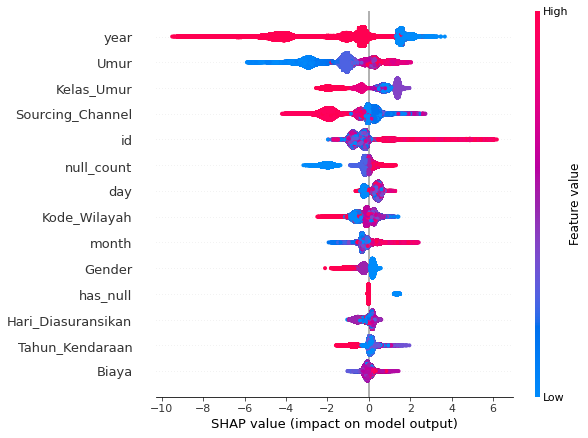

<Figure size 432x288 with 0 Axes>

In [84]:
# Plotting feature importance with shap values on XGBoost model
fig = plt.figure()
explainer = shap.TreeExplainer(xgb)

# Calculate shap values
shap_values = explainer.shap_values(tx)
#plot shap values
shap.summary_plot(shap_values, tx)
# plt.savefig('shap.png')

## Ensemble Method with Voting

In [54]:
smoten = SMOTEENN()
pln_cat = pipeline(steps=[('s', smoten), ('c', CatBoostClassifier(random_state=69, verbose=0))])
pln_xgb = pipeline(steps=[('s', smoten), ('x', XGBClassifier(objective='binary:logistic', eval_metric='error', random_state=69,
                      use_label_encoder=False))])

estimators = [
    ('xgb',XGBClassifier(objective='binary:logistic', eval_metric='error', random_state=69,
                      use_label_encoder=False, n_estimators=300)),
    ('cat1',CatBoostClassifier(iterations=300, cat_features=['Gender','Tahun_Kendaraan','Kode_Wilayah','Sourcing_Channel','day','month','year','has_null','Kelas_Umur'],
                         random_state=69, auto_class_weights='SqrtBalanced', verbose=0)),
    ('cat2',CatBoostClassifier(iterations=300, cat_features=['Gender','Tahun_Kendaraan','Kode_Wilayah','Sourcing_Channel','day','month','year','has_null','Kelas_Umur'],
                         random_state=69, auto_class_weights='Balanced', verbose=0)),
    ('smotecat', pln_cat),
    ('smotexgb', pln_xgb),
    ('lgbm', LGBMClassifier(n_estimators=300,random_state=69, categorical_feature=[2,4,3,6,10,11,12,13,9])),
    ('rf', RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_split=5,
                                   n_estimators=100, random_state=69))
]

vote = VotingClassifier(estimators = estimators, voting = 'soft')
vote.fit(tx,ty)

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            eval_metric='error', gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=...
                                                             reg_lambda=None,
                                                             scale_pos_weight=None

In [97]:
val_pred = vote.predict(valx)
print("Classification report of Ensemble Method Voting \n")
print(report(valy, val_pred,digits=5))

Classification report of Ensemble Method Voting 

              precision    recall  f1-score   support

           0    0.90186   0.97661   0.93775     47934
           1    0.79306   0.45751   0.58027      9390

    accuracy                        0.89158     57324
   macro avg    0.84746   0.71706   0.75901     57324
weighted avg    0.88404   0.89158   0.87919     57324



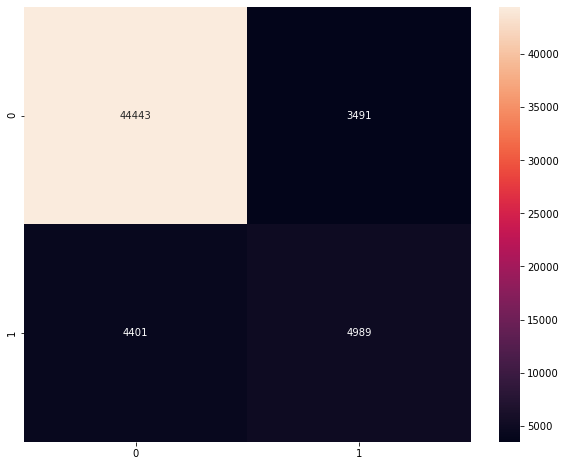

In [95]:
plt.figure(figsize=(10,8))
cor = cm(valy, val_pred)
sns.heatmap(cor, annot=True, fmt='.5g')
plt.savefig('cm.png')

## Submission

In [98]:
submission = pd.read_csv('sample_submission.csv')
pred = vote.predict(test)
submission['Target'] = pred
submission.to_csv('ElsiX submission.csv', index=False)

In [142]:
# Utilizing data leakage on test set
same_ids = list(set.intersection(set(train['id']), set(test['id'])))
mask = train[train.id.isin(same_ids)][['id','Target']]
mask = mask.set_index('id').Target

# replcae same ids with targte
for i,ids in enumerate(list(submission['id'])):
    if ids in same_ids:
        submission.loc[i,'Target'] = mask.loc[ids]

submission.to_csv('data leakage.csv', index=False)